In [1]:
import os
import sys
import math
import time
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# For classification (ResNet152V2)
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error

# For downloading pre-trained weights
import gdown

!git clone https://github.com/XGHouE/brain-tumor-analysis/

Cloning into 'brain-tumor-analysis'...
remote: Enumerating objects: 7816, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 7816 (delta 97), reused 45 (delta 30), pack-reused 7683 (from 1)
Receiving objects: 100% (7816/7816), 94.57 MiB | 9.81 MiB/s, done.
Resolving deltas: 100% (3176/3176), done.
Updating files: 100% (15296/15296), done.


# Data paths

UNet:

In [4]:
# Sort the image and mask filenames to ensure they match
image_files = sorted(os.listdir('/content/brain-tumor-analysis/SegmentationDataset/images'))
mask_files = sorted(os.listdir('/content/brain-tumor-analysis/SegmentationDataset/masks'))

IMAGES_PATH='/content/brain-tumor-analysis/SegmentationDataset/images'
MASKS_PATH='/content/brain-tumor-analysis/SegmentationDataset/masks'
SIZE=256
CHANNEL=1
Num_Of_Classes=1

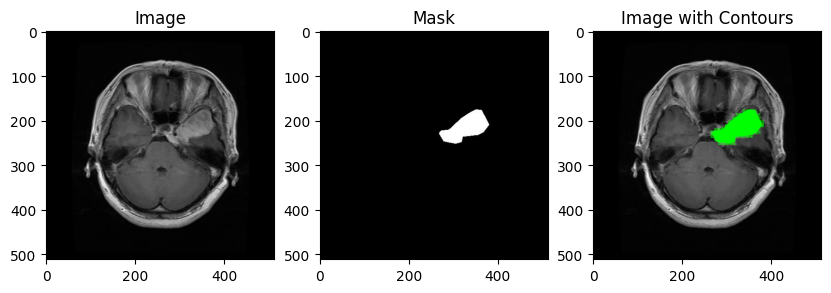

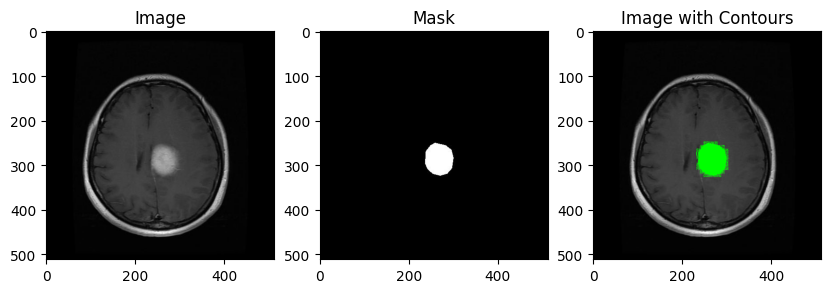

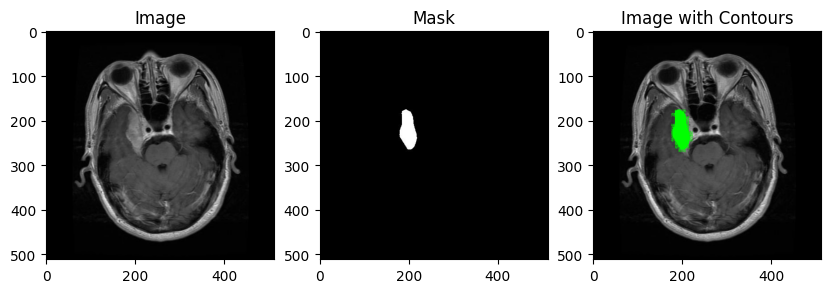

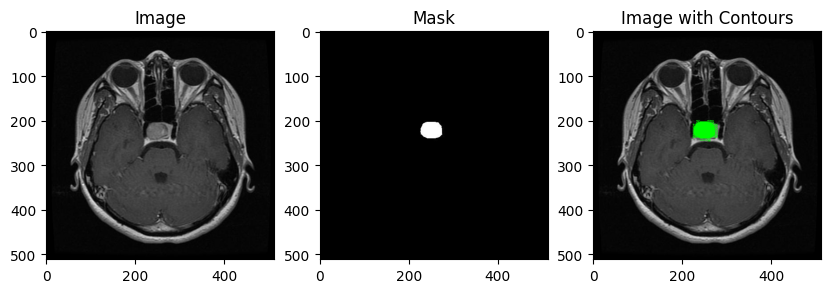

In [5]:
# Ensure data is imported correctly
def display_images_masks(imagepath, maskpath):
  count = 0
  for image_file, mask_file in zip(image_files, mask_files):
    if count >= 4:  # Display only the first 4 images from each folder
        break
    imagepath_full = os.path.join(imagepath, image_file)
    maskpath_full = os.path.join(maskpath, mask_file)
    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)
    if image is None:
        raise ValueError(f"Image at path {imagepath_full} could not be loaded")
    if mask is None:
        raise ValueError(f"Mask at path {maskpath_full} could not be loaded")
    plt.figure(figsize=(10, 10))
    # First subplot (image)
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    # Second subplot (mask)
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    # Third subplot (Image with Contours)
    plt.subplot(1, 3, 3)
    sample = np.array(np.squeeze(mask), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,1],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(image, contours, -1,[0,255,0], thickness=-1)
    plt.imshow(sample_over_gt)
    plt.title('Image with Contours')
    plt.show()
    count += 1

display_images_masks(IMAGES_PATH,MASKS_PATH)

In [6]:
images_size=[]
masks_size=[]
for image_file, mask_file in tqdm(zip(image_files, mask_files)):
    imagepath_full = os.path.join(IMAGES_PATH, image_file)
    maskpath_full = os.path.join(MASKS_PATH, mask_file)
    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)
    images_size.append(image.shape)
    masks_size.append(mask.shape)
print(list(set(images_size)))
print("=================")
print(list(set(masks_size)))

3064it [00:06, 449.97it/s]

[(512, 512, 3), (256, 256, 3)]
[(512, 512, 3), (256, 256, 3)]


In [ ]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files, mask_files)):


        imagepath_full = os.path.join(IMAGES_PATH, image_file)
        maskpath_full = os.path.join(MASKS_PATH, mask_file)

        image = cv2.imread(imagepath_full,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image = image/255.0
        images.append(image)

        mask = cv2.imread(maskpath_full,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE,SIZE))
        mask = mask/255.0
        masks.append(mask)

    return np.expand_dims(np.array(images), axis=-1), np.expand_dims(np.array(masks), axis=-1)

In [ ]:
# Split train and test
X,y=preprocessing_images_masks()
print('The Shape of X',X.shape)
print('The Shape of y',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

In [ ]:
# Helpful metrics to define...
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

ResNet

In [ ]:
train_dir = pathlib.Path('/content/brain-tumor-analysis/BrainTumorDataset/Training')
test_dir = pathlib.Path('/content/brain-tumor-analysis/BrainTumorDataset/Testing')

img_height = 512
img_width = 512
batch_size = 16
epochs = 20

In [ ]:
# Data Preprocesssing
# Loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
    shuffle=True,
    interpolation="bilinear",
    label_mode="int",
)

# Get class names
class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

# Normalize and apply data augmentation
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(512, 512),
    batch_size=batch_size,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Different classes have different weights...
def get_class_weights(train_ds, class_names):
    print("Calculating class weights...")

    labels = []
    for image_batch, label_batch in train_ds:
        labels.append(label_batch.numpy())

    labels = np.concatenate(labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}
    print("Class weights calculated.")
    return class_weight_dict

class_weight_dict = get_class_weights(train_ds, class_names)

# Define models

UNet

In [ ]:
def unet_model(input_size=(SIZE, SIZE, CHANNEL), num_classes=Num_Of_Classes):
    inputs = keras.layers.Input(input_size)

    # Encoding (Downsampling)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding (Upsampling)
    u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Create and compile the model
model = unet_model(input_size=(SIZE, SIZE,CHANNEL), num_classes=Num_Of_Classes)

model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy',dice_coef])
# Summary of the model
model.summary()

ResNet

In [ ]:
def create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, num_classes=4, learning_rate=0.0001, epochs=epochs, class_weight=None):
    for layer in base_model.layers[:10]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    print(f"\nSummary of {model_name}:")
    model.summary()

    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        train_ds,
        shuffle=True,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=[model_checkpoint, reduce_lr]
    )

    # End time tracking
    end_time = time.time()

    # Calculate computation time
    computation_time = end_time - start_time

    print(f"Model training took {computation_time:.2f} seconds.")

    print(f"\nEvaluating {model_name}...")
    print(f"\nClass Weights used in training {model_name}: {class_weight}")
    loss, accuracy = model.evaluate(test_ds)
    print('Loss:', loss)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    model.save(f'{model_name}.keras')
    evaluation = model.evaluate(test_ds)

    return model, history, evaluation, computation_time

In [ ]:
# Define the model
base_model3 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Training

UNet

In [ ]:
earlystopping=tf.keras.callbacks.EarlyStopping(patience=20,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=15,
                                                 min_lr=0.0001,
                                                 mode='min')
history = model.fit(X_train, y_train, batch_size=32, epochs=10,
                    validation_data=(X_test, y_test),
                    verbose=1, callbacks=[earlystopping, reduce_lr])

ResNet

In [ ]:
print(train_ds)
model3, history3, evaluation3, time3 = create_and_train_model(base_model3, 'model3_resnet152v2_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)

# Evaluation

UNet

In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
u_net_loss,u_net_accuracy,u_net_dice_coef=model.evaluate(X_test,y_test)
print(f'Loss is {u_net_loss}')
print(f'Accuracy is {u_net_accuracy}')
print(f'Dice_Coef is {u_net_dice_coef}')

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

In [ ]:
for i in range(50):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')

    plt.show()

ResNet

In [ ]:
def evaluate_model(model, test_ds, model_name):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nModel Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, precision, recall, f1, mae, rmse, cm

In [ ]:
# Define model names
model_names = ["ResNet152V2"]

# Store histories in a list
histories = [history3]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} Training')
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} Validation Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def preprocessing_images_masks(image_path='SegmentationDataset/images', mask_path='SegmentationDataset/masks', SIZE=256):
    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))
    images = []
    masks = []
    for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files)):
        image_full = os.path.join(image_path, image_file)
        mask_full = os.path.join(mask_path, mask_file)
        image = cv2.imread(image_full, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (SIZE, SIZE))
        image = image / 255.0
        images.append(image)
        mask = cv2.imread(mask_full, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE, SIZE))
        mask = mask / 255.0
        masks.append(mask)
    return np.expand_dims(np.array(images), axis=-1), np.expand_dims(np.array(masks), axis=-1)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-15):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def unet_model(input_size=(256, 256, 1), num_classes=1):
    inputs = keras.layers.Input(input_size)
    # Encoding (Downsampling)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding (Upsampling)
    u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
def run_unet_segmentation():
    print("Running UNet Brain Tumor Segmentation...")
    IMAGES_PATH = 'SegmentationDataset/images'
    MASKS_PATH = 'SegmentationDataset/masks'
    SIZE = 256
    CHANNEL = 1
    Num_Of_Classes = 1

    # Display sample images and masks
    display_images_masks(IMAGES_PATH, MASKS_PATH)

    # Print image and mask sizes
    image_files = sorted(os.listdir(IMAGES_PATH))
    mask_files = sorted(os.listdir(MASKS_PATH))
    images_size = []
    masks_size = []
    for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files)):
        image = cv2.imread(os.path.join(IMAGES_PATH, image_file))
        mask = cv2.imread(os.path.join(MASKS_PATH, mask_file))
        images_size.append(image.shape)
        masks_size.append(mask.shape)
    print("Unique image sizes:", list(set(images_size)))
    print("=================")
    print("Unique mask sizes:", list(set(masks_size)))

    # Preprocess images and masks
    X, y = preprocessing_images_masks(IMAGES_PATH, MASKS_PATH, SIZE)
    print('The Shape of X:', X.shape)
    print('The Shape of y:', y.shape)

    # Split into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)

    # Build and compile the UNet model
    model = unet_model(input_size=(SIZE, SIZE, CHANNEL), num_classes=Num_Of_Classes)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy', dice_coef])
    model.summary()

    # Set up callbacks
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.0001, mode='min')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=32, epochs=10,
                        validation_data=(X_test, y_test),
                        verbose=1, callbacks=[earlystopping, reduce_lr])

    # Plot training accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    u_net_loss, u_net_accuracy, u_net_dice_coef = model.evaluate(X_test, y_test)
    print(f'Loss: {u_net_loss}')
    print(f'Accuracy: {u_net_accuracy}')
    print(f'Dice Coefficient: {u_net_dice_coef}')

    # Generate predictions and visualize
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(np.uint8)
    for i in range(min(50, len(X_test))):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_test[i], cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_test[i].squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.show()

    # Optionally, download pre-trained UNet weights and load the model
    file_id = "1lxUFguKW-FQAqc_32plYclWMBT1t4_dQ"
    output_path = "unet_weights.keras"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
    model_path = "unet_weights.keras"  # Update path if necessary
    model = keras.models.load_model(model_path)

# ResNet

In [ ]:
def get_class_weights(train_ds, class_names):
    print("Calculating class weights...")
    labels = []
    for image_batch, label_batch in train_ds:
        labels.append(label_batch.numpy())
    labels = np.concatenate(labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}
    print("Class weights calculated.")
    return class_weight_dict

In [ ]:
def create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, num_classes=4, learning_rate=0.0001, epochs=20, class_weight=None):
    # Freeze first few layers of the base model
    for layer in base_model.layers[:10]:
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    print(f"\nSummary of {model_name}:")
    model.summary()
    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    start_time = time.time()
    history = model.fit(
        train_ds,
        shuffle=True,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=[model_checkpoint, reduce_lr]
    )
    end_time = time.time()
    computation_time = end_time - start_time
    print(f"Model training took {computation_time:.2f} seconds.")
    print(f"\nEvaluating {model_name}...")
    print(f"Class Weights used in training {model_name}: {class_weight}")
    loss, accuracy = model.evaluate(test_ds)
    print('Loss:', loss)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    model.save(f'{model_name}.keras')
    evaluation = model.evaluate(test_ds)
    return model, history, evaluation, computation_time

In [ ]:
def evaluate_model(model, test_ds, model_name):
    y_true = []
    y_pred = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nModel Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    return accuracy, precision, recall, f1, mae, rmse, cm

In [ ]:
def run_resnet_classification():
    print("Running ResNet152V2 Brain Tumor Classification...")
    # Dataset paths
    train_dir = pathlib.Path('BrainTumorDataset/Training')
    test_dir = pathlib.Path('BrainTumorDataset/Testing')
    img_height = 512
    img_width = 512
    batch_size = 16
    epochs = 20

    # Load training dataset with augmentation
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True,
        interpolation="bilinear",
        label_mode="int",
    )
    class_names = train_ds.class_names
    print("Classes in the dataset:", class_names)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
    ])
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    # Load validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
    )
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    # Load test dataset
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(img_height, img_width),
        batch_size=batch_size,
    )
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

    # Compute class weights
    class_weight_dict = get_class_weights(train_ds, class_names)

    # Define and train the model using ResNet152V2 as the base model
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    model_name = 'model3_resnet152v2_class_weights'
    model, history, evaluation, training_time = create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)

    # Plot training accuracy and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label=f'{model_name} Training')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot training loss and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Optionally, download pre-trained ResNet weights and load the model
    file_id = "1AeNDvpmbHhOnHQCHb8ytiQi08uvrVKRx"
    output_path = "ResNet152.keras"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
    model_path = "ResNet152.keras"  # Update path if needed
    model = keras.models.load_model(model_path)

    # Evaluate the model
    evaluate_model(model, test_ds, 'ResNet152V2')

# Dataset paths

In [ ]:
# Dataset paths
train_dir = pathlib.Path('BrainTumorDataset/Training')
test_dir = pathlib.Path('BrainTumorDataset/Testing')

img_height = 512
img_width = 512
batch_size = 16
epochs = 20

# Data augmentation

In [ ]:
# Dataset loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
    shuffle=True,
    interpolation="bilinear",
    label_mode="int",
)

# Get class names
class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

# Normalize and apply data augmentation
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(512, 512),
    batch_size=batch_size,
)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(512, 512),
    batch_size=batch_size,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 2442 files belonging to 4 classes.
Using 1954 files for training.
Classes in the dataset: ['1', '2', '3', 'notumor']
Found 2442 files belonging to 4 classes.
Using 488 files for validation.
Found 2133 files belonging to 4 classes.


# Balancing using class weights

In [ ]:
def get_class_weights(train_ds, class_names):
    print("Calculating class weights...")

    labels = []
    for image_batch, label_batch in train_ds:
        labels.append(label_batch.numpy())

    labels = np.concatenate(labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}
    print("Class weights calculated.")
    return class_weight_dict

class_weight_dict = get_class_weights(train_ds, class_names)

Calculating class weights...
Class weights calculated.


2025-03-03 16:33:35.447282: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, num_classes=4, learning_rate=0.0001, epochs=epochs, class_weight=None):
    for layer in base_model.layers[:10]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    print(f"\nSummary of {model_name}:")
    model.summary()

    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        train_ds,
        shuffle=True,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=[model_checkpoint, reduce_lr]
    )

    # End time tracking
    end_time = time.time()

    # Calculate computation time
    computation_time = end_time - start_time

    print(f"Model training took {computation_time:.2f} seconds.")

    print(f"\nEvaluating {model_name}...")
    print(f"\nClass Weights used in training {model_name}: {class_weight}")
    loss, accuracy = model.evaluate(test_ds)
    print('Loss:', loss)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    model.save(f'{model_name}.keras')
    evaluation = model.evaluate(test_ds)

    return model, history, evaluation, computation_time

In [ ]:
def evaluate_model(model, test_ds, model_name):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nModel Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, precision, recall, f1, mae, rmse, cm

# Train all models with 30 epochs

In [ ]:
# Define the model(s)
base_model3 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

In [ ]:
print(train_ds)
model3, history3, evaluation3, time3 = create_and_train_model(base_model3, 'model3_resnet152v2_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)

In [ ]:
# Define model names
model_names = ["ResNet152V2"]

# Store histories in a list
histories = [history3]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} Training')
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} Validation Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import gdown

file_id = "1AeNDvpmbHhOnHQCHb8ytiQi08uvrVKRx"
output_path = "ResNet152.keras"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1AeNDvpmbHhOnHQCHb8ytiQi08uvrVKRx
From (redirected): https://drive.google.com/uc?id=1AeNDvpmbHhOnHQCHb8ytiQi08uvrVKRx&confirm=t&uuid=38d01b8d-dbcb-4d7a-a9b1-bfd9f8c72d21
To: /Users/ahmedalsunbati/Documents/GitHub/brain-tumor-analysis/ResNet152.keras
100%|██████████| 714M/714M [00:30<00:00, 23.3MB/s] 


'ResNet152.keras'

In [ ]:
from tensorflow import keras

model_path = "ResNet152.keras"  # Update the path if needed
model = keras.models.load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━

2025-03-03 23:26:57.661857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


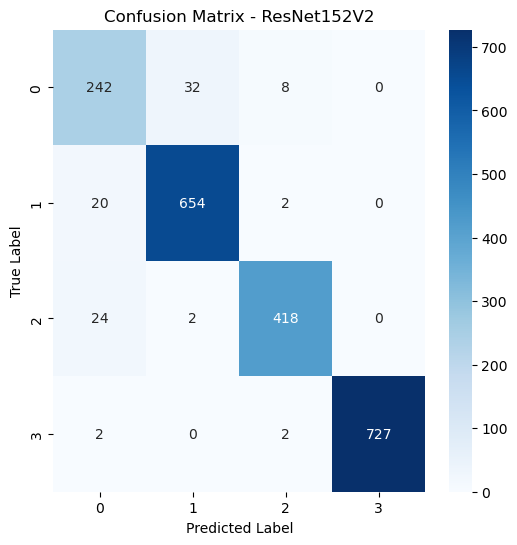

(0.956868260665729,
 0.9574124045544907,
 0.956868260665729,
 0.9570506943718992,
 0.06000937646507267,
 0.09563994374120956,
 array([[242,  32,   8,   0],
        [ 20, 654,   2,   0],
        [ 24,   2, 418,   0],
        [  2,   0,   2, 727]]))

In [ ]:
#After training model(s)
evaluate_model(model, test_ds, 'ResNet152V2')